#Import the necessary libraries

In [1]:
!pip install dlib # how to from https://github.com/ageitgey/face_recognition/issues/175
# !pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 57.0 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=3301373 sha256=4d030d73fcfa0f11021470b59eaa10b4c74629858db479f36466cf57cf19ea81
  Stored in directory: /root/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
Successfully built dlib


In [1]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 14.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=3301368 sha256=2c4b2579486d3823ecf90390c02c6a9be03344c6c5bd7d569c6f6b426febff8a
  Stored in directory: /root/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566165 sha256=c0ddf7389281e858ed26fa60e85c1928e58eec13eac226fb4e17a1a465eed312
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built dlib face-recognition-models


In [10]:
import cv2, sys, os, joblib
from glob import glob
from tqdm.notebook import trange, tqdm
import numpy as np

# !pip instal dlib # how to from https://github.com/ageitgey/face_recognition/issues/175
# !pip install face_recognition
import dlib # Landmarks algorithme
import math
from skimage import feature 
from skimage.feature import hog
import random
import pandas as pd

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import seaborn as sns 
home = '/content/drive/MyDrive/Final_Dataset/'


# Detect faces and draw landmarks with DLIP

In [5]:

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/kaggle/input/model/shape_predictor_68_face_landmarks.dat')


def draw_face_landmarks(img_path, flag = False):
    img = cv2.imread(img_path)
    image = cv2.imread(img_path, 0)
    detections = detector(image, 1)
    best_face = 0
    xm, ym, wm, hm = 0, 0, 0, 0
    if len(detections) > 1:
        
        max_surface = 0
        
        for i, face in enumerate(detections):
            # Finding points for rectangle to draw on face
            xi, yi, wi, hi = face.left(), face.top(), face.width(), face.height()
            if wi*hi > max_surface:
                xm, ym, wm, hm = xi, yi, wi, hi
                max_surface = wi*hi
                best_face = i
    elif len(detections) < 1:
        return None

    for f, face in enumerate(detections):
        # Draw Facial Landmarks with the predictor class
        shape = predictor(image, face)
        xlist = []
        ylist = []
        for i in range(68):  # Store X and Y coordinates in two lists
            xlist.append(int(shape.part(i).x))
            ylist.append(int(shape.part(i).y))

        def draw_line(x, y, g=True):
            if g:
                cv2.line(img, (xlist[x], ylist[x]),
                         (xlist[y], ylist[y]), (0, 255, 0), 1)
            else:
                cv2.line(img, (xlist[x], ylist[x]),
                         (xlist[y], ylist[y]), (155, 0, 247), 1)
        g = False
        if f == best_face:
            g = True

        for i in range(16):
            draw_line(i, i+1, g)
        for i in range(17, 21):
            draw_line(i, i+1, g)
        for i in range(22, 26):
            draw_line(i, i+1, g)
        for i in range(36, 41):
            draw_line(i, i+1, g)
        draw_line(36, 41, g)
        for i in range(42, 47):
            draw_line(i, i+1, g)
        draw_line(42, 47, g)

        for i in range(27, 35):
            draw_line(i, i+1, g)
        draw_line(30, 35, g)

        for i in range(48, 59):
            draw_line(i, i+1, g)
        draw_line(48, 59, g)
        for i in range(60, 67):
            draw_line(i, i+1, g)
        draw_line(60, 67, g)

    # Drawing simple rectangle around found faces
    if flag and xm is not None:
        cv2.rectangle(img, (xm, ym), (xm + wm, ym + hm), (0, 0, 255), 2)
#     cv2.imwrite(home+'4_2.png', img)
    return img

In [6]:
def get_face_landmarks(img_path, flag=False):
    """
   Another way to detect the face.
    """
    image = cv2.imread(img_path, 0)
    try:
        detections = detector(image, 1)
    except:
        return None
    
    # On s'interisse au visage de grande dimension qui est le plus proche dans l'image
    best_face_id = 0
    if len(detections) > 1:
        max_surface = 0
        xm, ym, wm, hm = 0, 0, 0, 0
        for i, face in enumerate(detections):
            # Finding points for rectangle to draw on face
            xi, yi, wi, hi = face.left(), face.top(), face.width(), face.height()
            if wi*hi > max_surface:
                xm, ym, wm, hm = xi, yi, wi, hi
                max_surface = wi*hi
                best_face_id = i
    elif len(detections) < 1:
        return None
    
    # Draw Facial Landmarks with the predictor class
    shape = predictor(image, detections[best_face_id])
    xlist = []
    ylist = []
    for i in range(68):  # Store X and Y coordinates in two lists
        xlist.append(int(shape.part(i).x))
        ylist.append(int(shape.part(i).y))
    # Estimation de visage
    xmin, xmax, ymin, ymax = np.min(xlist), np.max(
        xlist), np.min(ylist), np.max(ylist)
    w, h = xmax-xmin, ymax-ymin
    if ymin <= h/3:
        ymin = 0
    else:
        ymin -= int(h/3)

    if xmin <= w/5:
        xmin = 0
    else:
        xmin -= int(w/5)

    wight = image.shape[1]
    if xmax >= wight-w/5:
        xmax = wight
    else:
        xmax += int(w/5)
    
    if flag:
        face_seg = cv2.imread(img_path)[ymin:ymax, xmin:xmax]
    else:
        face_seg = image[ymin:ymax, xmin:xmax]
        face_seg = cv2.resize(face_seg, (96, 96), interpolation = cv2.INTER_AREA)
    return face_seg

In [7]:
def pltC(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_img(list_img):
    fig, ax = plt.subplots(1, len(list_img), figsize=(22, 8),
                       subplot_kw=dict(xticks=[], yticks=[]))
    
    for i, (img, title) in enumerate(list_img):
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(title)
    plt.show()

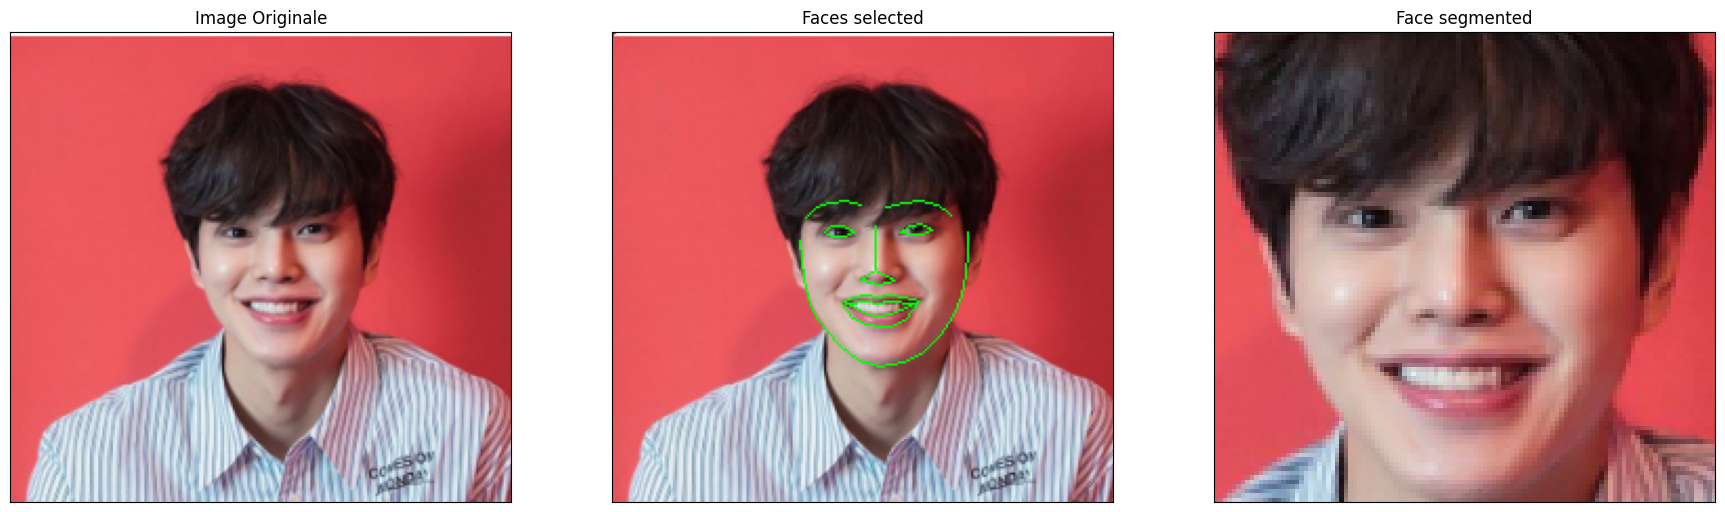

In [11]:
img_path = '/kaggle/input/data-new/test_happy.png'

img = cv2.imread(img_path)
plot_img([(pltC(img), 'Image Originale'), (pltC(draw_face_landmarks(img_path, True)), 'Faces selected'), (pltC(get_face_landmarks(img_path, True)), 'Face segmented')])

In [14]:
def our_ft_landmark(X, Y):
    """ 
     In this function we used the points of landmark for the extraction features that we calculate distance
     between the points of the following parts: between the nose and the eyes, the eyes and the eyebrows and the mouth and the nose...
     After this calculation we do the normalization of data to manage the problems related to the difference of human faces
    """
    def get_degre(i,j):
        myradians = math.atan2(Y[i]-Y[j], X[i]-X[j])
        return math.degrees(myradians)

    f_x = [30,30,30,30,30,30,21,17,22,43,42,38,36,62,51,48,51]
    f_y = [26,54,17,48,22,21,22,21,26,47,45,40,39,66,57,54,30]
    features = []

    for i,j in zip(f_x,f_y):
        features.append(np.linalg.norm( (X[i]-X[j],Y[i]-Y[j]) ) )

    features = list(features / np.mean(features))# normalisation des données
    
    features2 = []
    features2.append((get_degre(30,26)-90))
    features2.append((get_degre(30,22)-90))
    features2.append((90-get_degre(30,17)))
    features2.append((90-get_degre(30,21)))
    features2.append((get_degre(30,54)*-1-90))
    features2.append((90-get_degre(30,48)*-1))

    features.extend(np.array(features2)/100)
    return features

In [15]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/kaggle/input/model/shape_predictor_68_face_landmarks.dat')


def get_landmarks(image): # from https://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/
    """
    In this function we recover the points of landmarks and the features (our_ft_landmark)
    """
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detections = detector(image, 1)
    if len(detections) < 1: # Number of faces detected = 0
        # print("Number of faces detected: {}".format(len(detections)))
        return None
    # Draw Facial Landmarks with the predictor class
    shape = predictor(image, detections[0])
    xlist = []
    ylist = []
    for i in range(68):  # Store X and Y coordinates in two lists
        xlist.append(float(shape.part(i).x))
        ylist.append(float(shape.part(i).y))

    landmarks_vectorised = []
    landmarks_vectorised = our_ft_landmark(xlist, ylist)# Extaraction des features

    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = [(x-xmean) for x in xlist]
    ycentral = [(y-ymean) for y in ylist]
    
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
#       landmarks_vectorised.append(x)
#       landmarks_vectorised.append(y)
        meannp = np.asarray((ymean, xmean))
        coornp = np.asarray((z, w))
        dist = np.linalg.norm(coornp-meannp)# Distance euclidienne
        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))# Calcule de l'ongle entre le moyenne et un point

    return landmarks_vectorised

In [16]:
def get_local_binary_pattern(image, numPoints, radius, eps=1e-7):
    """
   ** Feature extraction based on texture: **
     The LBP method contains information about the distribution of local micro-patterns.

     Facial expressions can be viewed as a composition of micro-patterns
     which can be effectively described by LBP features.

     An LBP histogram presents only the occurrences of micro-patterns without any indication of their location.

     @args: image (image to process)
     @return hist (LBP histogram)
    """
    lbp = feature.local_binary_pattern(
        image, numPoints, radius, method="uniform")

    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(
        0, numPoints + 3), range=(0, numPoints + 2))

    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    # return the histogram of Local Binary Patterns
    return hist  # , lbp

In [17]:
def get_hog(img, visualize=False):
    # Feature extraction using Histogram of oriented gradient
    return hog(img, orientations=6, pixels_per_cell=(9, 9), cells_per_block=(1, 1), visualize = visualize)


In [18]:
def get_hog1(img, visualize=False):
    # Feature extraction using Histogram of oriented gradient
    img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return hog(img, orientations=6, pixels_per_cell=(9, 9), cells_per_block=(1, 1), visualize = visualize)


In [19]:
faceDet = cv2.CascadeClassifier("/kaggle/input/detector-model/haarcascade_frontalface_default.xml")
faceDet2 = cv2.CascadeClassifier("/kaggle/input/detector-model/haarcascade_frontalface_default.xml")
faceDet4 = cv2.CascadeClassifier("/kaggle/input/detector-model/haarcascade_frontalface_default.xml")
faceDet3 = cv2.CascadeClassifier("/kaggle/input/detector-model/haarcascade_frontalface_default.xml")
def face_extractor(img_path, flag = False):
    gray = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # Face detection: it can detect aberrant data (an object is not clear can be considered like a face
    faces = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) < 1:
        faces = faceDet2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
        print(2)
        if len(faces) < 1:
            print(3)
            faces = faceDet3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
            if len(faces) < 1:
                print(4)
                faces = faceDet4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
                if len(faces) < 1:
                    return None
    # We are interested in the large face that is closest in the image       
    max_surface = 0
    x, y, w,h = 0, 0, 0, 0
    for (xi, yi, wi,hi) in faces:
        if wi*hi > max_surface:
            x, y, w,h = xi, yi, wi,hi
            max_surface = wi*hi
    if(w*h!=0):
        #if h = 0 or w = 0 (nothing detected), our function returns None,
         # otherwise we determine the face well so we extract it according to the new height and width
        if flag:
            face_seg = cv2.imread(img_path)[y:y+h, x:x+w]
        else:
            face_seg = gray[y:y+h, x:x+w]
            # we normalize the height and width of the images h=96 and w=96
            face_seg = cv2.resize(face_seg, (96, 96), interpolation = cv2.INTER_AREA) # Resize face so all images have same size
        return face_seg
    
    return None

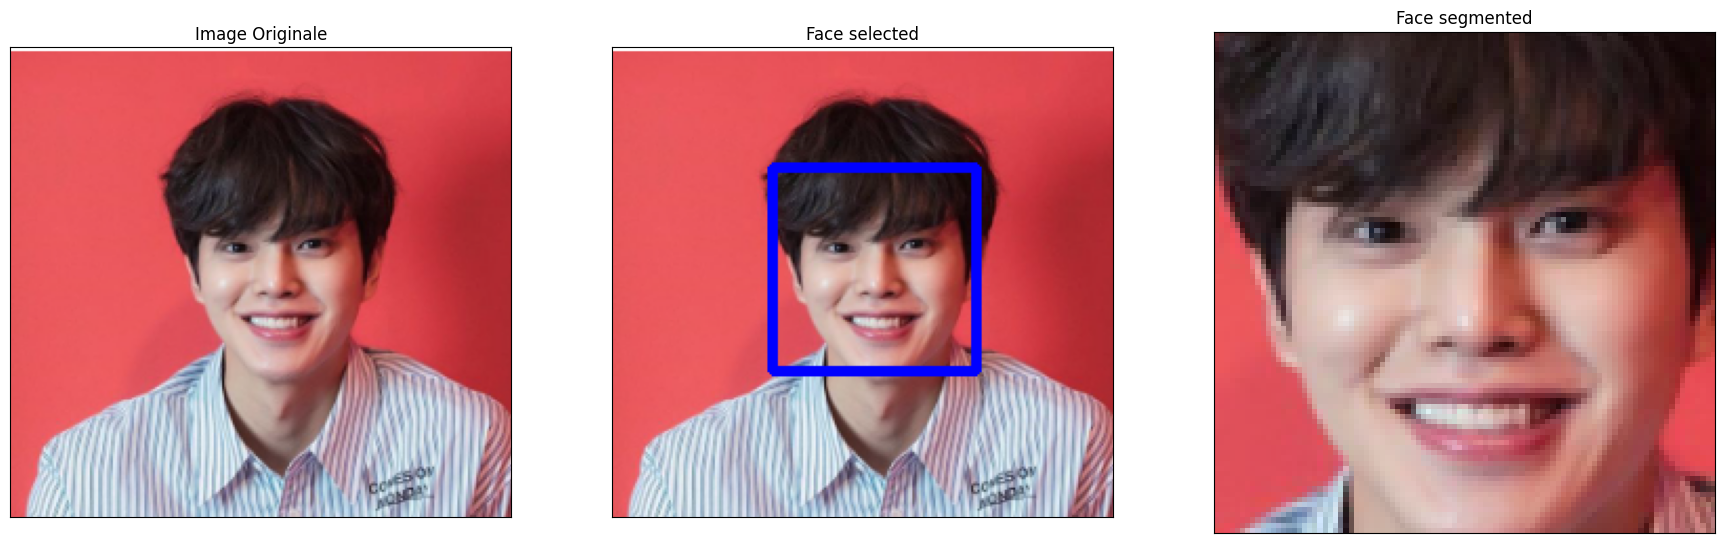

In [20]:
img_path = '/kaggle/input/data-new/test_happy.png'
original_img = cv2.imread(img_path)
img = original_img.copy()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = faceDet.detectMultiScale(img_gray , scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

for (x, y , w ,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0 , 0), 3)

max_surface = 0
x, y , w ,h = 0,0,0,0
for (xi, yi , wi ,hi) in faces:
    if wi*hi > max_surface:
        x, y , w ,h = xi, yi , wi ,hi
        max_surface = wi*hi
if(w*h==0):
    print('[no face detected]')
    sys.exit()
face_seg = original_img[y:y+h,x:x+w]

plot_img([(pltC(original_img), 'Image Originale'), (pltC(img), 'Face selected'), (pltC(face_seg), 'Face segmented')])

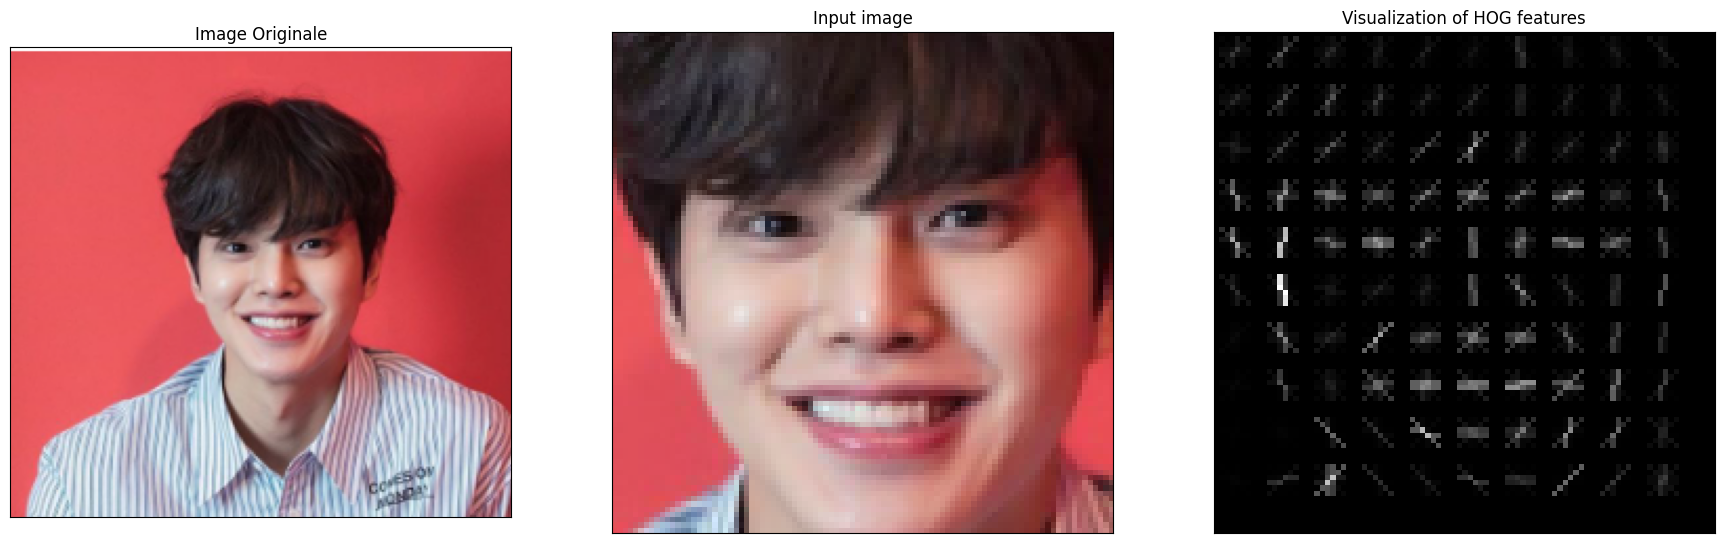

In [21]:
img_path = '/kaggle/input/data-new/test_happy.png'
img = mpimg.imread(img_path)
face_seg = face_extractor(img_path, True)
hog_vec, hog_vis = get_hog1(face_seg, visualize=True)
plot_img([(img, 'Image Originale'), (pltC(face_seg), 'Input image'), (hog_vis, 'Visualization of HOG features')])

In [22]:
def sliding_hog_windows(image):
    """
    Extraction of features using Hog with the sliding window method For each window,
    we superimpose it with each region of our image in order to detect the object that interests us.
    """
    # initialization
    image_height, image_width  = 48, 48
    window_size = 24
    window_step = 6
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1)))
    return hog_windows

In [23]:
def build_filters():
	filters = []
	ksize = 9
	#define the range for theta and nu
	for theta in np.arange(0, np.pi, np.pi / 8):
		for nu in np.arange(0, 6*np.pi/4 , np.pi / 4):
			kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
			kern /= 1.5*kern.sum()
			filters.append(kern)
	return filters

#---------------------------------------------------
#function to convolve the image with the filters
def process(img, filters):
	accum = np.zeros_like(img)
	for kern in filters:
		fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
		np.maximum(accum, fimg, accum)
	return accum
  
def extracting_features_gabor_filter_bank(imgg):
    #instantiating the filters
    filters = build_filters()
    f = np.asarray(filters)
    #initializing the feature vector
    feat = []
    #calculating the local energy for each convolved image
    for j in range(40):
        res = process(imgg, f[j])
        temp = 0
        for p in range(imgg.shape[0]):
            for q in range(imgg.shape[1]):
                temp = temp + res[p][q]*res[p][q]
        feat.append(temp)
    #calculating the mean amplitude for each convolved image	
    for j in range(40):
        res = process(imgg, f[j])
        temp = 0
        for p in range(imgg.shape[0]):
            for q in range(imgg.shape[1]):
                temp = temp + abs(res[p][q])
            feat.append(temp)
    #feat matrix is the feature vector for the image
    #print(feat)
    return feat

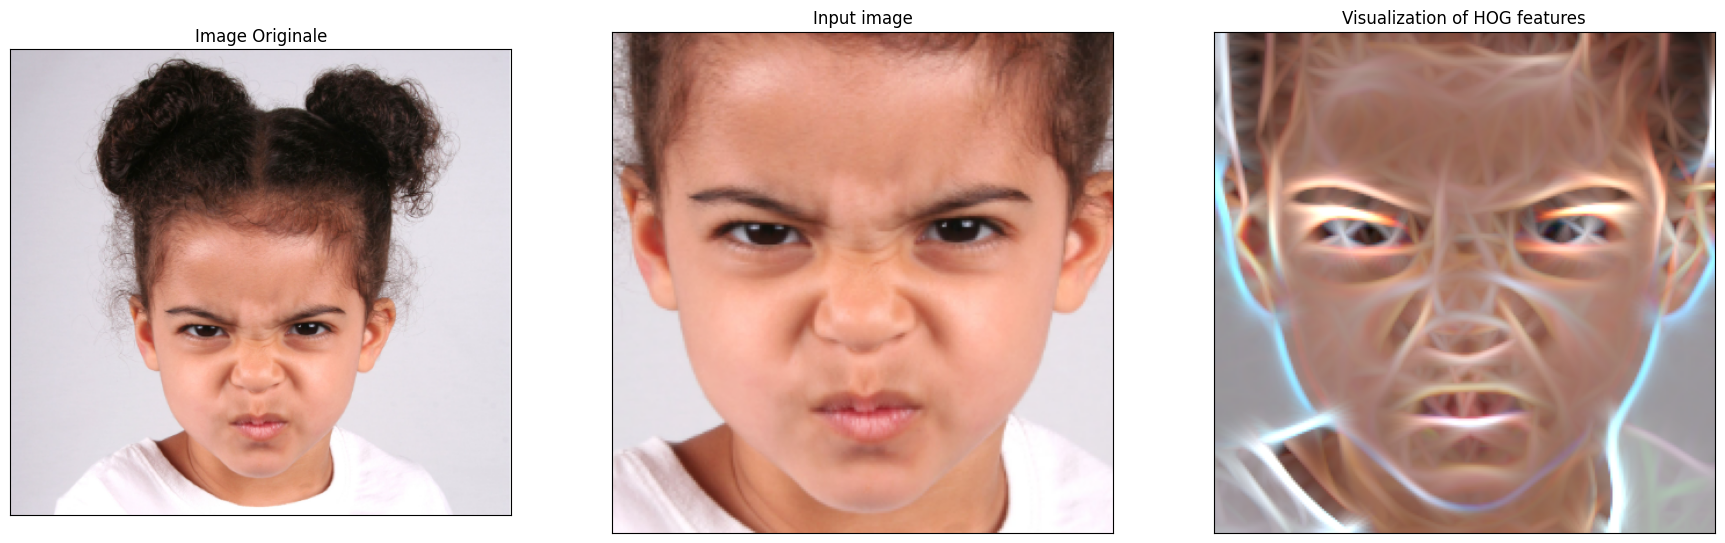

In [25]:
def build_filters1():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process1(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

img_path = '/kaggle/input/data-new/test_angry.png'
img = mpimg.imread(img_path)
face_seg = face_extractor(img_path, True)

filters = build_filters1()
img_gabor = process1(face_seg , filters)
plot_img([(img, 'Image Originale'), (pltC(face_seg), 'Input image'), (pltC(img_gabor), 'Visualization of HOG features')])

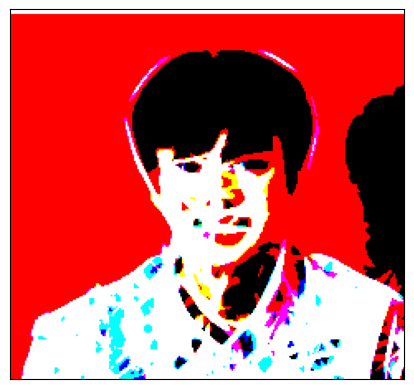

In [27]:
img_path = '/kaggle/input/data-new/test_happy.png'
img = mpimg.imread(img_path)
img = process1(img , filters)
cv2.imwrite('/kaggle/input/data-new/test_happy.png', pltC(img))
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.show()

In [36]:
"""
contrast limited adaptive histogram equalization: variant of Adaptive histogram equalization (AHE)
which improves the contrast of an image
"""
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def get_feature(img_path, face_cut=False):
    # All faces dimensions  = (96,96)
    if face_cut:
        img = face_extractor(img_path)
        

    else:
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (96, 96), interpolation=cv2.INTER_AREA)

    if img is None:
        img = get_face_landmarks(img_path)
        if img is None:
            return None

    ft_landmarks = get_landmarks(img.copy()) # len = 295
    if ft_landmarks is None:
        return None
    
    try:
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_AREA)#Pour reduire features de Hog
    except:
        return None

    ft_hog = get_hog(img.copy()) # len = 150
    ft_shogw = sliding_hog_windows(img.copy()) # len = 2592
    ft_gabor = extracting_features_gabor_filter_bank(img.copy()) # len= 1960
   
    global_feature = np.concatenate([ft_landmarks, ft_gabor, ft_hog, ft_shogw]).flatten() # shape = 4997
    
    return global_feature

## LOAD DATA

In [31]:
path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [32]:
X = df['pth'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [57]:
X_train

array(['neutral/ffhq_1666.png', 'surprise/image0025690.jpg',
       'sad/image0002414.jpg', ..., 'neutral/ffhq_2576.png',
       'happy/ffhq_3510.png', 'contempt/image0035030.jpg'], dtype=object)

In [68]:
dirname='/kaggle/input/affectnet-training-data/'
def extract_features_from_images(image_paths):
    feature_vectors = []
    error = []
    error_idx = []
    for index, image_path in enumerate(image_paths):
        try:
            # Extract features from each image
            feature_vector = get_feature(dirname + image_path, True)
            # Append the feature vector to the list
            if feature_vector is not None and len(feature_vector) != 0:
                feature_vector = feature_vector.reshape(1,-1)
                feature_vectors.append(feature_vector)
            else:
                error_idx.append(index)
        except Exception as e:
            error.append(image_path)
            error_idx.append(index)

            continue

    
    feature_vectors = np.vstack(feature_vectors)

    output_file_path = f'/kaggle/working/error_img.txt'
    np.savetxt(output_file_path, error, fmt='%s')
    return feature_vectors, error_idx

In [72]:
x_train_process, idx1 = extract_features_from_images(X_train[:11270])
x_train_process.shape

/tmp/ipykernel_33/2162263434.py:33: RuntimeWarning: overflow encountered in scalar multiply
  temp = temp + res[p][q]*res[p][q]


2
3
4


(9, 4997)

In [ ]:
np.save('/kaggle/working/x_train_b1.npy', x_train_process)

In [ ]:
x_test_process, idx2 = extract_features_from_images(X_test)

In [ ]:
np.save('/kaggle/working/x_test.npy', x_test_process)

In [ ]:
def y_processing(y, idx):
    mask = np.ones_like(y, dtype=bool)
    mask[idx] = False

    # Use boolean indexing to get the elements you want to keep
    y = y[mask]
    return y

y_train = y_processing(y_train[:5635], idx1)
y_test = y_processing(y_test,idx2)
label_encoder = LabelEncoder()
# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train).reshape(-1,1)
y_test = label_encoder.transform(y_test).reshape(-1,1)
y_train.shape
    

In [ ]:
np.save('/kaggle/working/y_train_b1.npy', y_train)
np.save('/kaggle/working/y_test.npy', y_test)
np.save('/kaggle/working/idx_train_b1.npy', idx1)
np.save('/kaggle/working/idx_test.npy', idx2)